In [2]:
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from datetime import datetime
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account("5fe30e6c8e71223b5549d253025a1f141713265617a67216a3f92d3dd3ea08be71b7676a82869b7ad89d2ddcd67a117acaf2e0434f3c525b730f30bb234df6e3", overwrite=True)
provider = IBMProvider()
from QLSTM import SequenceDataset
import yfinance as yf
from pandas_datareader import data as pdr

In [3]:
df = pd.read_csv("final_combined_mutation_dataset.csv")


In [4]:
features = [
    "Encoded_Sequence",       # This is a list
    "Geo_Location",
    "Tissue_Specimen_Source",
    "Collection_Year",
    "Body_Temperature",
    "Parasite_Density"
]
target = "Mutation_Label"


In [5]:
columns = ['Open', 'High', 'Low', 'Close']

In [6]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
# Correctly split original dataframe
df_train = df.iloc[:size].copy()
df_test = df.iloc[size:].copy()

In [7]:
columns = ['Collection_Year', 'Body_Temperature', 'Parasite_Density']
target = "Mutation_Label"
features = columns

# Include the target column too
df_train = df_train[columns + [target]]
df_test = df_test[columns + [target]]
size = int(len(df) * 0.7)
df_train = df.iloc[:size].copy()
df_test = df.iloc[size:].copy()

In [8]:
data = df.filter(columns)
dataset = data.values

In [9]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [10]:
# Only normalize numeric columns
numeric_cols = ['Collection_Year', 'Body_Temperature', 'Parasite_Density']
target = 'Mutation_Label'

# Normalize only the numeric part
df_train[numeric_cols], min_train, max_train = normalize(df_train[numeric_cols])
df_test[numeric_cols], _, _ = normalize(df_test[numeric_cols], min_train, max_train)


In [11]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    dataframe=df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    dataframe=df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3])
Target shape: torch.Size([1])


In [12]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        X = X.unsqueeze(1)  # Add sequence dimension
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.unsqueeze(1)  # Add sequence dimension
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss


def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [13]:
from QLSTM import QShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    n_qubits=7,
    n_qlayers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 7)


In [14]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 285


In [15]:
from torch.utils.data import Subset, DataLoader

# ⚡ Reduce dataset size
small_train = Subset(train_dataset, range(100))
small_test = Subset(test_dataset, range(100))

# ⚡ Use smaller batch size for speed
train_loader = DataLoader(small_train, batch_size=8, shuffle=True)
test_loader = DataLoader(small_test, batch_size=8, shuffle=False)

# Training loop
quantum_loss_train = []
quantum_loss_test = []

print("Untrained test\n--------")
test_loss = test_model(test_loader, Qmodel, loss_function)
quantum_loss_test.append(test_loss)

num_epochs = 150  # ⚡ Fewer epochs for speed

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)


Untrained test
--------
Test loss: 0.24411164224147797
Epoch 0
---------
Train loss: 0.2567475655904183
Test loss: 0.25317271512288314
Execution time 9.638346433639526
Epoch 1
---------
Train loss: 0.2515387053673084
Test loss: 0.25787129539709824
Execution time 8.958634853363037
Epoch 2
---------
Train loss: 0.24929296855743116
Test loss: 0.25329132034228397
Execution time 9.008281230926514
Epoch 3
---------
Train loss: 0.24965504041084877
Test loss: 0.25315844554167527
Execution time 9.375607252120972
Epoch 4
---------
Train loss: 0.24875564300096953
Test loss: 0.2544486327813222
Execution time 8.76184606552124
Epoch 5
---------
Train loss: 0.2496431596004046
Test loss: 0.2589720544906763
Execution time 8.879162073135376
Epoch 6
---------
Train loss: 0.2506831999008472
Test loss: 0.25941667648462147
Execution time 8.65230393409729
Epoch 7
---------
Train loss: 0.2505349104221051
Test loss: 0.25792306203108567
Execution time 8.94881272315979
Epoch 8
---------
Train loss: 0.24981949879

In [16]:
print(df_test.columns)


Index(['Encoded_Sequence', 'Geo_Location', 'Tissue_Specimen_Source',
       'Collection_Year', 'Body_Temperature', 'Parasite_Density',
       'Mutation_Label'],
      dtype='object')


In [33]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Qmodel.to(device)
Qmodel.eval()

# Ensure tensors
if not isinstance(X_train, torch.Tensor):
    X_train = torch.tensor(X_train, dtype=torch.float32)
if not isinstance(X_test, torch.Tensor):
    X_test = torch.tensor(X_test, dtype=torch.float32)

X_train = X_train.to(device)
X_test = X_test.to(device)

# ❗ Add dimension for sequence_length = 1
X_train = X_train.unsqueeze(1)  # Now shape is (batch, 1, features)
X_test = X_test.unsqueeze(1)

with torch.no_grad():
    y_pred_train = Qmodel(X_train).cpu().numpy()
    y_pred_test = Qmodel(X_test).cpu().numpy()


In [34]:
num_batches = len(test_loader)
print(f"Number of batches: {num_batches}")


Number of batches: 24


In [35]:
# Use full test set for predictions
test_loader = DataLoader(test_dataset, batch_size=13, shuffle=False)

# Predictions on all 300 test samples
y_pred = []

Qmodel.eval()
with torch.no_grad():
    for X_batch in test_loader:
        if isinstance(X_batch, (tuple, list)):
            X_batch = X_batch[0]
        
        X_batch = X_batch.unsqueeze(1)  # Now shape = [batch_size, 1, features]
        
        outputs = Qmodel(X_batch)
        preds = torch.sigmoid(outputs)
        preds = preds.cpu().numpy()
        y_pred.extend(preds)

y_pred = np.array(y_pred).flatten()

# Now assign predictions to df_test
assert len(y_pred) == len(df_test), f"Length of predictions ({len(y_pred)}) does not match length of test data ({len(df_test)})"

df_test["Model_Prediction"] = y_pred  # Assign predictions to df_test


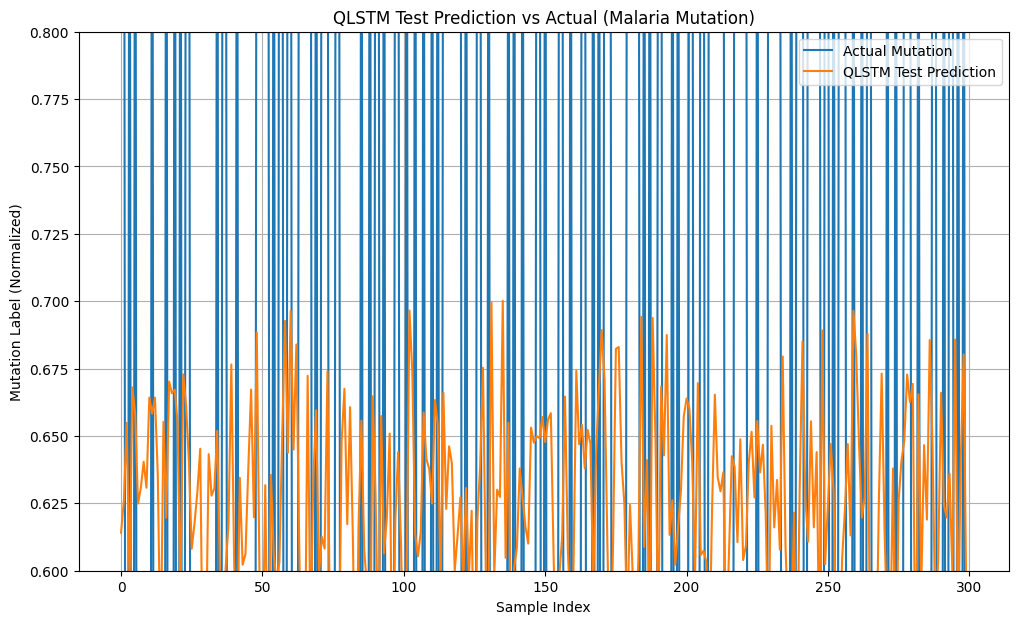

In [36]:
plt.figure(figsize=(12, 7))

# Plot actual mutation label
plt.plot(range(len(df_test)), df_test["Mutation_Label"], label="Actual Mutation")

# Plot predictions
plt.plot(range(len(df_test)), df_test["Model_Prediction"], label="QLSTM Test Prediction")

# Set y-axis limits to zoom in on the 0.6 to 0.8 range
plt.ylim(0.6, 0.8)

# Labels and title
plt.ylabel('Mutation Label (Normalized)')
plt.xlabel('Sample Index')
plt.title("QLSTM Test Prediction vs Actual (Malaria Mutation)")

# Display legend
plt.legend()

# Show grid for easier reading
plt.grid(True)

# Show plot
plt.show()


In [37]:
X_train = df_train[numeric_cols].values
X_test = df_test[numeric_cols].values


In [38]:
df_train["Model_Prediction"] = y_pred_train
df_test["Model_Prediction"] = y_pred_test


In [40]:
import numpy as np  # just in case

# ✅ Correct binary accuracy function
def accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Convert predictions to binary (0 or 1) using 0.5 threshold
    y_pred_binary = (y_pred > 0.5).astype(int)

    return (y_pred_binary == y_true).mean()

# Use it
train_accuracy = accuracy(df_train["Mutation_Label"], df_train["Model_Prediction"])
test_accuracy = accuracy(df_test["Mutation_Label"], df_test["Model_Prediction"])

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Train accuracy: 0.5286
Test accuracy: 0.4267


In [41]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_mutation_Model.pt")

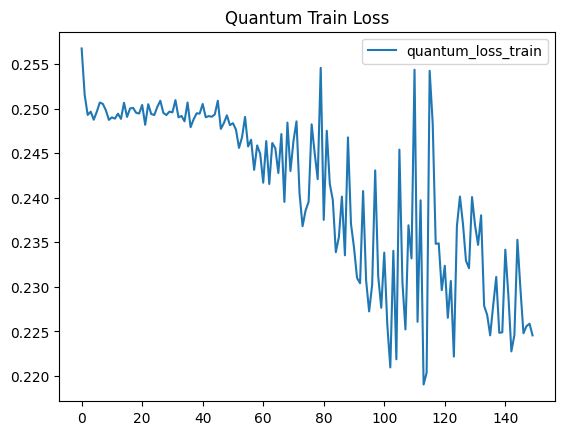

In [42]:
plt.plot(quantum_loss_train, label='quantum_loss_train')
# plt.plot(quantum_loss_test, label='quantum_loss_test')  # Uncomment if you have test loss
pd.DataFrame(quantum_loss_train).to_csv('QLSTM_loss.csv', index=False)
plt.title('Quantum Train Loss')
plt.legend()
plt.show()


In [43]:
from QLSTM import QLSTM  # or from your own definition

input_dim = 3          # Encoded_Sequence, Geo_Location, Body_Temperature
hidden_dim = 32
num_layers = 1
output_dim = 1

quantum_model = QLSTM(input_dim, hidden_dim, num_layers, output_dim)


weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 1)


In [44]:
torch.save(quantum_model.state_dict(), "quantum_model.pth")


In [45]:
quantum_model.load_state_dict(torch.load("quantum_model.pth"))
quantum_model.eval()


QLSTM(
  (clayer_in): Linear(in_features=35, out_features=1, bias=True)
  (clayer_out): Linear(in_features=1, out_features=32, bias=True)
)

In [46]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Prepare test tensor
X_test = df_test[numeric_cols].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # [batch, seq, features]

# Step 2: Create dummy dataset & loader
test_dataset = TensorDataset(X_test_tensor, torch.zeros(len(X_test_tensor)))  # dummy labels
test_eval_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 3: Inference with sigmoid
quantum_model.eval()
all_predictions = []

with torch.no_grad():
    for x_batch, _ in test_eval_loader:
        output = quantum_model(x_batch)
        if isinstance(output, tuple):
            output = output[0]
        preds = torch.sigmoid(output).cpu().numpy().flatten()  # ✅ Apply sigmoid
        all_predictions.extend(preds)

# Step 4: Save as mutation percentages (optional: multiply by 100)
df_result = pd.DataFrame({"Predicted Mutation %": [round(p * 100, 2) for p in all_predictions]})
df_result.to_csv("QLSTM_mutation_predictions.csv", index=False)
print("✅ Predictions saved to 'QLSTM_mutation_predictions.csv'")


✅ Predictions saved to 'QLSTM_mutation_predictions.csv'
